## IR Group 42

    1. Kashyap Rajpurohit (2023ab05027)
    2. Sayanta CHaterjee (2023aa05173) 
    3. Pooja Patila (2023aa05194) 
    4. Tapan Kumar Polleyee (2022DC04205)

### Problem Statement 
1. Write a function to construct a positional index for preprocessed documents (Tokenization, stop word removal, stemming). Implement  SPIMI algorithm for index construction.

#### Construction a positional index for preprocessed documents and implement the SPIMI (Single-Pass In-Memory Indexing) algorithm

A ***positional index*** , also known as an inverted index with positions or a positional inverted index, is a data structure used primarily in information retrieval systems to store information about the occurrences of words in a collection of documents. It not only keeps track of which documents contain which terms but also records the exact positions of each term within the documents. This allows for more advanced search capabilities, such as phrase searches or proximity queries.

### Key Components of a Positional Index:
**Term:** A word or token from the documents.
**Document ID (DocID):** Identifier for each document in the collection.
**Positions:** List of positions within the document where the term appears.
**Structure:** For each term, the index stores a list of documents, and for each document, it stores a list of positions where the term appears.

**SPIMI (Single-Pass In-Memory Indexing)** is an algorithm used in information retrieval to build an inverted index from a large collection of documents efficiently. It operates in a single pass over the document collection, processing each document or block of documents only once. This approach helps manage memory efficiently, especially when dealing with large datasets that cannot fit entirely into memory.

**Uses:**
    Phrase Queries: To find documents containing a specific sequence of words (e.g., "cat in the hat").
    Proximity Searches: To find documents where terms appear within a certain distance from each other.
    Efficient Search: Faster retrieval of documents containing specific terms or phrases.

**Implementation:**
Creating a positional index involves tokenizing the text, recording the positions of each term, and organizing this information in a searchable format. This structure allows for efficient and powerful search functionalities in information retrieval systems.

**Single-Pass Processing:** SPIMI processes each document or block of documents exactly once. This reduces the overhead of multiple passes over the entire document collection, making it suitable for large datasets.

**In-Memory Processing:** Despite the name, SPIMI often uses disk-based storage for posting lists. However, it minimizes the amount of data held in memory at any given time by processing documents in blocks and writing partial results (blocks) to disk as needed.

**Tokenization and Posting List Construction:**
Tokenization: Each document is tokenized (split into terms or tokens).
Posting List Construction: For each term encountered in a document, SPIMI updates or constructs a posting list. This list contains document identifiers (IDs) and optionally positions where the term occurs within each document.

**Dictionary-Based Index Construction:**
SPIMI maintains an in-memory dictionary (or hash table) where keys are terms and values are their respective posting lists.
As each document is processed, SPIMI updates this dictionary.

**Block-Based Index Storage:**
To manage memory efficiently, SPIMI writes out blocks of the dictionary to disk when they reach a predefined size or memory threshold.
Each block typically corresponds to a subset of terms and their associated posting lists.

**Merge Process:**
After processing all documents, SPIMI may involve a merge phase where blocks are read from disk and merged into a final inverted index.
During merging, duplicate terms across different blocks are resolved, and postings for each term are aggregated.

Source of info. : Self Study and various.

### install the required libraries 

In [ ]:
!pip install python-docx nltk

In [2]:
import os
from docx import Document
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import defaultdict, Counter
import string
import nltk
import re

# Download NLTK data
# -- punctuation library
nltk.download('punkt')
# -- stop word library
nltk.download('stopwords')

# Initializations
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
BLOCKSIZE = 100000
# This notebook is located in the path D:\MySource\01NoteBooks\101 WILP\02IR\Assignment-1 and hence the relative path definition
DOCPATH = { "docx" : "./BBC_Sport/docs", 
             "txt" : "./BBC_Sport/text" }

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\usha_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\usha_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessing: 

    The preprocess function tokenizes the input text, removes stop words, numbers, special characters and applies stemming.
    

In [4]:
# Preprocess the document
def preprocess(text):    
    # Tokenization
    tokens = word_tokenize(text)
    # Convert to lower case
    tokens = [token.lower() for token in tokens]
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    # Remove numbers and special characters
    for each in range(len(tokens)):
        tokens[each] = re.sub(r'\d+', '', tokens[each])  
        tokens[each] = re.sub(r'[^\w\s]', '', tokens[each])     
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]    
    # Stemming    
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

## Input dataset: 

Take your own source of files (should be a combination of doc, txt, pdf and excel files, minimum of 25 files, each with minimum 300 words). Select the source files in such a way that they belong to two different categories (SPORTS AND POLITICS).

The dataset basically is sourced from 
    https://www.kaggle.com/datasets

THe dataset contains summarized BBC Sports new articles and reports. 

The input dataset consists of about 6 Micorsoft Word files and 30 text files. 
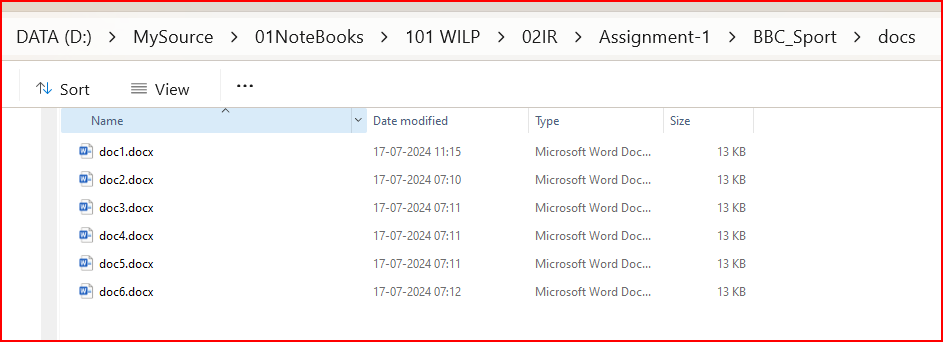

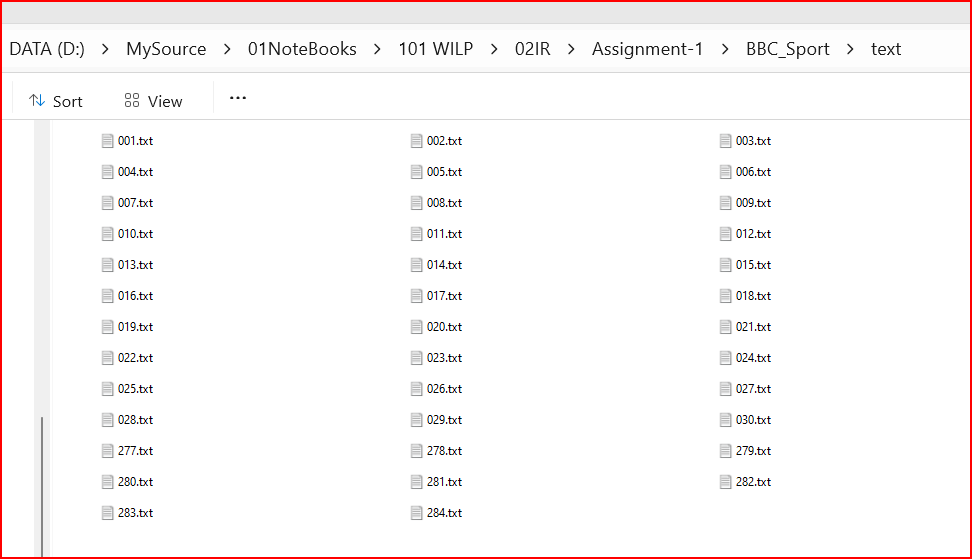

In [7]:
# Read documents from the directory

def read_multiple_docx(directory):
    documents_content = {}    
    for filename in os.listdir(directory["docx"]):
        if filename.endswith('.docx'): # Consider only .docx files
            file_path = os.path.join(directory["docx"], filename)
            doc = Document(file_path)
            content = []
            for para in doc.paragraphs:
                content.append(para.text)
            documents_content[filename] = preprocess('\n'.join(content))
    file_contents = {}        
    for filename in os.listdir(directory["txt"]):
        if filename.endswith(".txt"):  # Consider only .txt files
            filepath = os.path.join(directory["txt"], filename)
            with open(filepath, 'r') as file:
                file_contents[filename[:-4]] = preprocess(file.read())  
    documents_content.update(file_contents)
    return documents_content

#### SPIMI Algorithm (function):

    The spimi_invert function iterates through each document, preprocesses it, and then updates the positional index with the term positions for each document.

    This approach ensures that each term in the positional index maps to a dictionary, where the keys are document IDs and the values are lists of positions of the term within the document.


In [15]:
"""
# SPIMI Algorithm for positional Index Construction
# Initializing blocksize of 100000
# Then, each document is Tokenized into terms.
    For each term, update its posting list in the dictionary (add document ID and optionally position).
"""                                                                  
def spimi_invert(token_stream, block_size=BLOCKSIZE):
    dictionary = defaultdict(list)
    block_id = 0

    for token, doc_id, pos in token_stream:
        dictionary[token].append((doc_id, pos))
        if len(dictionary) >= block_size:
            write_block_to_disk(dictionary, block_id)
            dictionary = defaultdict(list)
            block_id += 1
    
    if dictionary:
        write_block_to_disk(dictionary, block_id)

    return block_id

def write_block_to_disk(dictionary, block_id):
    with open(f'block_{block_id}.txt', 'w') as file:
        for term, postings in sorted(dictionary.items()):
            file.write(f'{term}: {postings}\n')

def merge_blocks(num_blocks):
    final_index = defaultdict(list)

    for block_id in range(num_blocks+1):
        with open(f'block_{block_id}.txt', 'r') as file:
            for line in file:
                term, postings = line.strip().split(': ')
                postings = eval(postings)
                final_index[term].extend(postings)

    return final_index

In [17]:
""" 
    Demonsrtation of construction of a positional index for preprocessed documents and implementation of...
    ... the SPIMI (Single-Pass In-Memory Indexing) algorithm  
"""

print (f"\n1. Read dataset")
documents = read_multiple_docx(DOCPATH)

print (f"\n2. Pre-processing Complete.")
# Create token stream
token_stream = []
for doc_id, (filename, tokens) in enumerate(documents.items()):
    for pos, token in enumerate(tokens):
        token_stream.append((token, doc_id, pos))
print(f"\n3. Created token stream.")

# Construct positional index using SPIMI
print (f"\n4. Start constructing positional index using SPIMI algorithm..")
num_blocks = spimi_invert(token_stream)
print (type(num_blocks))
print (num_blocks)
positional_index = merge_blocks(num_blocks)

# Print positional index
print (f"\n5. Printing Positional Index:")
for term, postings in sorted(positional_index.items()):
    print(f'{term}: {postings}')

print (f"6. End (Solution to Question-1 of the assignment).")


1. Read dataset

2. Pre-processing Complete.

3. Created token stream.

4. Start constructing positional index using SPIMI algorithm..
<class 'int'>
0

5. Printing Positional Index:
: [(0, 18), (0, 28), (0, 29), (0, 30), (0, 31), (1, 21), (1, 23), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (3, 27), (5, 15), (5, 31), (6, 31), (6, 36), (6, 39), (6, 42), (6, 46), (6, 54), (6, 126), (7, 30), (7, 47), (7, 89), (8, 31), (8, 39), (8, 45), (8, 53), (8, 57), (8, 61), (8, 74), (8, 80), (8, 88), (8, 101), (8, 106), (8, 116), (8, 151), (8, 182), (8, 195), (8, 198), (8, 206), (9, 29), (9, 31), (9, 37), (9, 46), (9, 50), (9, 59), (9, 60), (9, 78), (9, 93), (9, 96), (9, 104), (10, 17), (10, 19), (10, 26), (10, 52), (10, 56), (10, 57), (10, 64), (10, 67), (10, 79), (10, 98), (11, 14), (11, 62), (11, 66), (11, 73), (11, 83), (12, 13), (12, 24), (12, 33), (13, 3), (13, 29), (13, 44), (13, 47), (13, 50), (13, 66), (13, 78), (13, 80), (13, 94), (13, 111), (13, 112), (13, 117), (14, 17), (14, 3

#### Question 2: 
    Show how optimization of Boolean query evaluation can be done with the inverted index generated in part(a).

Optimizing Boolean query evaluation using the inverted index involves leveraging the structure of the index to quickly retrieve and intersect postings lists. 

Step-by-Step Approach
1. Convert the Query to Conjunctive Normal Form (CNF): This allows us to handle queries involving AND, OR, and NOT or Complementary operation.
2. Retrieve Postings Lists: For each term in the query, retrieve its postings list from the positional index.
3. Optimize Intersection Order: Intersect postings lists starting with the smallest to minimize the number of comparisons.
4. Perform the Boolean Operations: Intersect (AND), union (OR), and difference (NOT) on postings lists.


Query Evaluation:
    The evaluate_boolean_query function parses the query, retrieves postings lists for each term, and evaluates the query using the Boolean operations.

Optimization:
    By starting with the smallest postings list for intersections, we minimize the number of comparisons, which improves efficiency.    

In [19]:
"""
    First implement the utility functions for Boolean operations on query terms
"""
def intersect (ltup1, ltup2):
    set1 = set(ltup1)
    set2 = set(ltup2)
    intersection = set1 & set2
    return intersection
    
def union (ltup1, ltup2):
    set1 = set(ltup1)
    set2 = set(ltup2)
    union = set1 | set2
    return union

# a complement b
def a_not_in_b (ltup1, ltup2):
    set1 = set(ltup1)
    set2 = set(ltup2)
    not_in_set1 = set2 - set1
    return not_in_set1

# b complement a 
def b_not_in_a (ltup1, ltup2):
    set1 = set(ltup1)
    set2 = set(ltup2)
    not_in_set2 = set1 - set2
    return not_in_set2

In [35]:
"""
    Retrieve postings list for a term from the positional index.
"""
def get_postings(keys, index):    
    extracted = {key: index[key] for key in keys if key in index}
    return extracted  

"""
    Evaluate a Boolean query on the positional index.    
    The Parameters are..
    query (str): Boolean query in CNF form
    index (defaultdict): Positional index    
    Returns:
    List of document IDs (tuples) satisfying the query
"""
def boolean_query_evalutation(query, index):
    
    # Split the query into terms and operators
    terms = re.findall(r'\b\w+\b', query.lower())
    operators = re.findall(r'AND|OR|NOT', query.upper())
    print (f"terms: {terms}")
    print (f"operators : {operators}")

    # Preprocess terms
    terms = [stemmer.stem(term) for term in terms if term not in stop_words]
    
    # Retrieve postings lists for each term
    postings_lists = get_postings(terms, index)
    # print (f"postings_lists: {postings_lists}")  
        
    # Evaluate the query
    if not operators:        
        return postings_lists.get(terms[0], [])

    result = postings_lists[terms[0]]
    i = 1

    while i < len(terms):
        operator = operators[i - 1]
        if operator == 'AND':
            # print (f"param1:{result}, param2:{postings_lists[terms[i]]}")
            result = intersect(result, postings_lists[terms[i]])                        
        elif operator == 'OR':
            result = union(result, postings_lists[terms[i]])            
        elif operator == 'NOT':
            result = complement(result, postings_lists[terms[i]])            
        i += 1

    return result

# Demo
print ()
query = "Blair AND Bush"
result = boolean_query_evalutation(query, positional_index)
print(f"Documents matching the query '{query}': {result}")
print ()
query = "Britain OR France"
result = boolean_query_evalutation(query, positional_index)
print(f"Documents matching the query '{query}': {result}")
print ()
query = "tennis OR hewitt"
result = boolean_query_evalutation(query, positional_index)
print(f"Documents matching the query '{query}': {result}")
print()


terms: ['blair', 'and', 'bush']
operators : ['AND']
Documents matching the query 'Blair AND Bush': set()

terms: ['britain', 'or', 'france']
operators : ['OR']
Documents matching the query 'Britain OR France': {(18, 72), (11, 36), (43, 162), (14, 4), (20, 14), (14, 62), (27, 4), (43, 174), (7, 29), (39, 129), (41, 99), (14, 202), (14, 208), (4, 16), (25, 83), (34, 26), (39, 130), (15, 107), (30, 129), (40, 260), (17, 83), (16, 22), (30, 19), (27, 93), (8, 127), (8, 156), (43, 153)}

terms: ['tennis', 'or', 'hewitt']
operators : ['OR']
Documents matching the query 'tennis OR hewitt': {(0, 1), (1, 18), (2, 6), (1, 5), (1, 29), (1, 19), (2, 0)}

